In [1]:
import chess
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# Define the mapping from piece symbols to plane indices
# White pieces are in planes 0-5, Black pieces are in planes 6-11
piece_to_plane = {
    ('P', chess.WHITE): 0,
    ('N', chess.WHITE): 1,
    ('B', chess.WHITE): 2,
    ('R', chess.WHITE): 3,
    ('Q', chess.WHITE): 4,
    ('K', chess.WHITE): 5,
    ('p', chess.BLACK): 6,
    ('n', chess.BLACK): 7,
    ('b', chess.BLACK): 8,
    ('r', chess.BLACK): 9,
    ('q', chess.BLACK): 10,
    ('k', chess.BLACK): 11,
}

In [3]:
def board_to_tensor(board: chess.Board) -> torch.Tensor:
    """
    Convert a python-chess board object to a (17, 8, 8) PyTorch Tensor
    The 17 planes:
    - 0-5: White pieces (P, N, B, R, Q, K)
    - 6-11: Black pieces (p, n, b, r, q, k)
    - 12: Player to move (1 for white, 0 for black)
    - 13: White's kingside castling right
    - 14: White's queenside castling right
    - 15: Black's kingside castling right
    - 16: Black's queenside castling right
    """

    # Initialize a 17x8x8 NumPy array with zeros
    tensor_np = np.zeros((17, 8, 8), dtype=np.float32)

    # Populate piece planes (0 - 11)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            # Get the plane index for the piece type and color
            plane_idx = piece_to_plane[(piece.symbol(), piece.color)]

            # The board is read from A1 to H8, but we want a standard matrix view
            # rank (row) 7 -> 0, 6 -> 1, ..., 0 -> 7
            # file (col) 0 -> 0, 1 -> 1, ..., 7 -> 7
            rank = chess.square_rank(square)
            file = chess.square_file(square)
            tensor_np[plane_idx, 7-rank, file] = 1
    
    # Populate state planes (12 - 16)
    # Plane 12: PLayer to move
    if board.turn == chess.WHITE:
        tensor_np[12, :, :] = 1
    else:
        tensor_np[12, :, :] = 0 # Not necessary due to np.zeros, but for clarity

    # Plane 13 - 16: Castling rights
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor_np[13, :, :] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor_np[14, :, :] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor_np[15, :, :] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor_np[16, :, :] = 1

    return torch.from_numpy(tensor_np)


In [4]:
# --- Example usage ---

# Create the board object 
board = chess.Board()

# Convert the board to tensor
board_tensor = board_to_tensor(board)

# Print the shape
print(f"Shape of the tensor: {board_tensor.shape}")

# Let's check a few planes to see if it's correct
print("\nWhite pawns plane (should have 1s on the 2nd rank from bottom):")
print(board_tensor[0])

print("\nPlayer to move plane (should be all 1s for white):")
print(board_tensor[12])

Shape of the tensor: torch.Size([17, 8, 8])

White pawns plane (should have 1s on the 2nd rank from bottom):
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

Player to move plane (should be all 1s for white):
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])


In [5]:
class ChessDataset(Dataset):
    """
    Custom PyTorch Dataset for our chess data.
    """
    def __init__(self, csv_file, limit = None):
        """
        Args:
            csv_file (string): Path to the csv file with FENs and evaluations.
        """
        self.dataframe = pd.read_csv(csv_file)
        if limit:
            # Slice the dataframe to the specified limit
            self.dataframe = self.dataframe.head(limit)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the FEN string and evaluation from the dataframe
        fen = self.dataframe.iloc[idx]['FEN']
        evaluation = self.dataframe.iloc[idx]['Evaluation'].lstrip('#')


        # Create a board object
        board = chess.Board(fen)
        
        # Convert the board to our tensor representation
        board_tensor = board_to_tensor(board)
        

        # --- Normalize the evaluation score ---
        # The raw score is in centipawns. Let's clamp it to a reasonable range,
        # for example -1000 to +1000, which is like a +/- 10 pawn advantage.
        # Then, we can scale it to the [-1, 1] range.
        score = float(evaluation)
        score_clamped = max(min(score, 1000), -1000)
        # A simple scaling to [-1, 1]
        normalized_score = score_clamped / 1000.0
        
        # Convert score to a tensor
        eval_tensor = torch.tensor([normalized_score], dtype=torch.float32)

        return board_tensor, eval_tensor

In [6]:
# --- Example Usage ---

# 1. Create an instance of our dataset
# Make sure you have 'chessData.csv' (or a sample of it) in the same directory
try:
    # Let's use the main dataset file
    csv_path = 'dataset/ChessData.csv'
    chess_dataset = ChessDataset(csv_file=csv_path, limit = 200000)
    print(f"Successfully loaded {len(chess_dataset)} positions from {csv_path}")

    # 2. Create a DataLoader
    # This will handle batching, shuffling, and can even use multiple CPU cores
    batch_size = 64
    data_loader = DataLoader(chess_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    # 3. Iterate over a few batches to see it in action
    print(f"\nTesting the DataLoader with a batch size of {batch_size}...")
    for i, (boards, evals) in enumerate(data_loader):
        print(f"Batch {i+1}:")
        print("  Boards tensor shape:", boards.shape) # Should be (batch_size, 17, 8, 8)
        print("  Evals tensor shape:", evals.shape)   # Should be (batch_size, 1)
        
        # We only need to check a few batches
        if i == 2:
            break
            
except FileNotFoundError:
    print("Error: Make sure 'ChessData.csv' is in the same directory as the script.")
    print("You can download it from the Kaggle link you provided.")

Successfully loaded 200000 positions from dataset/ChessData.csv

Testing the DataLoader with a batch size of 64...
Batch 1:
  Boards tensor shape: torch.Size([64, 17, 8, 8])
  Evals tensor shape: torch.Size([64, 1])
Batch 2:
  Boards tensor shape: torch.Size([64, 17, 8, 8])
  Evals tensor shape: torch.Size([64, 1])
Batch 3:
  Boards tensor shape: torch.Size([64, 17, 8, 8])
  Evals tensor shape: torch.Size([64, 1])


In [7]:
class ActorCritic(nn.Module):
    """
    An Actor-Critic network for our chess bot.
    The network shares a convolutional body and has two heads:
    1. Policy Head (Actor): Outputs move probabilities.
    2. Value Head (Critic): Outputs a scalar value for the position
    """
    def __init__(self, num_actions=4672):
        super(ActorCritic, self).__init__()
        # --- Shared Convolutional Body ---
        # Input shape: (batch_size, 17, 8, 8)
        self.conv1 = nn.Conv2d(17, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # The output of the conv layers will be (batch_size, 256, 8, 8)
        self.linear_input_size = 256 * 8 * 8

        # --- Critic Head ---
        self.value_head = nn.Sequential(
            nn.Linear(self.linear_input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Tanh() # Outputs a value between -1 and 1
        )

        # --- Actor Head ---
        self.policy_head = nn.Sequential(
            nn.Linear(self.linear_input_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions) # Outputs logits for each possible action
        )

    def forward(self, x):
        # Pass through the shared body
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Flatten the output for the linear layers
        x = x.view(-1, self.linear_input_size)

        # Calcualte value and policy
        value = self.value_head(x)
        policy_logits = self.policy_head(x)

        return policy_logits, value

1. The Shared Convolutional Body (The "Eyes" of the Bot)

Why Convolutional Layers (Conv2d)?
Your input tensor (17, 8, 8) is structured like a multi-layered image. Convolutional Neural Networks (CNNs) are the industry standard for image recognition because they are brilliant at finding spatial patterns.

    In chess, these "patterns" are things like pawn structures, open files, king safety, knight outposts, and tactical motifs.

    A Conv2d layer slides a small filter (the kernel) across the 8x8 board to detect these patterns. A kernel_size=3 means it looks at a 3x3 square at a time.

    Using padding=1 with a kernel_size=3 is a common trick to ensure the output of the layer is the same size as the input (8x8), preventing the board representation from shrinking.

Why Multiple Layers?
The network builds a hierarchy of knowledge:

    conv1 (First Layer): Learns very simple patterns, like "a white pawn is on this square" or "a bishop is attacking this square."

    conv2 and conv3 (Deeper Layers): Combine the simple patterns from earlier layers into more complex and abstract concepts, like "this is a fianchetto structure" or "the king is exposed." Increasing the number of channels (from 17 to 128, then to 256) allows the network to learn more of these patterns at each level.

Why Batch Normalization (BatchNorm2d) and ReLU?

    BatchNorm2d: This is a crucial regularization technique that helps make training faster and more stable. It normalizes the activations from the previous layer, preventing the signals from becoming too large or too small, which can stall the learning process.

    ReLU (F.relu): This is the activation function. It introduces non-linearity, allowing the network to learn complex relationships. It's essentially the "on/off switch" for the detected patterns.

2. The Critic Head (The "Coach")

After the convolutional body has extracted all the important features into a high-level representation, this information is flattened into a long 1D vector (self.linear_input_size).

Why Linear Layers?
The nn.Linear layers act as the final decision-making part. They take the collection of identified patterns and learn to weigh their importance to calculate a final score.

Why output a single number and use Tanh?

    The goal of the Critic is to answer one question: "How good is this position?" The answer is a single number.

    The nn.Tanh activation function is the key here. It squashes the output into a strict range between -1 and 1. This is critical because we normalized our training data (the Stockfish evaluations) to be in this exact same range. This makes the training objective very clear: make the network's output match the normalized expert score.

3. The Actor Head (The "Player")

The Actor head also receives the same flattened vector of features from the shared body.

Why output num_actions values?

    The Actor's job is to choose a move. It does this by assigning a score (a logit) to every single possible move in our predefined list (we used num_actions=4672). A higher logit means the network thinks that move is better.

    We don't use an activation function like softmax here because the loss function we'll use for training the policy (Cross-Entropy Loss) prefers to work directly with the raw logits for better numerical stability.

In [8]:
# --- Example Usage ---
# Let's create an instance of our network
model = ActorCritic()
print("Model created successfully:")
print(model)

# Now let's test it with a dummy batch of data from our DataLoader
# This simulates one step of training
dummy_batch_size = 4
dummy_board_tensor = torch.randn(dummy_batch_size, 17, 8, 8)

# Get the model's output
policy_logits, value_estimate = model(dummy_board_tensor)

print("\n--- Testing with a dummy batch ---")
print(f"Input shape: {dummy_board_tensor.shape}")
print(f"Output policy logits shape: {policy_logits.shape}") # Should be (batch_size, 4672)
print(f"Output value estimate shape: {value_estimate.shape}")   # Should be (batch_size, 1)

Model created successfully:
ActorCritic(
  (conv1): Conv2d(17, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (value_head): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): Tanh()
  )
  (policy_head): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=4672, bias=True)
  )
)

--- Testing with a dummy batch ---
Input shape: torch.Size([4, 17, 8, 8])
Output polic

In [9]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
# --- Setup for Training ---

# Instantiate the model and move it to the selected device
model = ActorCritic().to(device)

# Define the loss function and optimizer
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# --- The Training Loop ---

num_epochs = 3 # A few epochs are enough for a demonstration
# (For real training, you'd run this for many more epochs)

print("\n--- Starting Critic Pre-training ---")

for epoch in range(num_epochs):
    total_loss = 0.0
    
    # Set the model to training mode
    model.train()
    
    for i, (board_tensors, true_evals) in enumerate(data_loader):
        # Move tensors to the correct device
        board_tensors = board_tensors.to(device)
        true_evals = true_evals.to(device)

        if epoch == 0 and i == 0:
            print(f"Sanity Check: Min eval: {torch.min(true_evals)}, Max eval: {torch.max(true_evals)}")
        
        # 1. Zero the gradients
        optimizer.zero_grad()
        
        # 2. Forward pass: get the model's output
        # We only care about the value output for this training step
        _ , predicted_evals = model(board_tensors)
        
        # 3. Calculate the loss
        loss = criterion(predicted_evals, true_evals)
        
        # 4. Backward pass: compute gradients
        loss.backward()
        
        # 5. Update the model's weights
        optimizer.step()
        
        total_loss += loss.item()
        
        # Print progress every 100 batches
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Batch [{i+1}/{len(data_loader)}], "
                  f"Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    print(f"\n--- Epoch {epoch+1} Finished ---")
    print(f"Average Loss for Epoch: {avg_loss:.4f}\n")

print("--- Pre-training Finished ---")




--- Starting Critic Pre-training ---
Sanity Check: Min eval: -0.8669999837875366, Max eval: 0.8240000009536743
Epoch [1/3], Batch [100/3125], Loss: 0.0618
Epoch [1/3], Batch [200/3125], Loss: 0.0443
Epoch [1/3], Batch [300/3125], Loss: 0.0477
Epoch [1/3], Batch [400/3125], Loss: 0.0414
Epoch [1/3], Batch [500/3125], Loss: 0.0581
Epoch [1/3], Batch [600/3125], Loss: 0.0481
Epoch [1/3], Batch [700/3125], Loss: 0.0654
Epoch [1/3], Batch [800/3125], Loss: 0.0700
Epoch [1/3], Batch [900/3125], Loss: 0.0695
Epoch [1/3], Batch [1000/3125], Loss: 0.0386
Epoch [1/3], Batch [1100/3125], Loss: 0.0356
Epoch [1/3], Batch [1200/3125], Loss: 0.0515
Epoch [1/3], Batch [1300/3125], Loss: 0.0610
Epoch [1/3], Batch [1400/3125], Loss: 0.0567
Epoch [1/3], Batch [1500/3125], Loss: 0.0567
Epoch [1/3], Batch [1600/3125], Loss: 0.0353
Epoch [1/3], Batch [1700/3125], Loss: 0.0487
Epoch [1/3], Batch [1800/3125], Loss: 0.0307
Epoch [1/3], Batch [1900/3125], Loss: 0.0432
Epoch [1/3], Batch [2000/3125], Loss: 0.06

In [12]:
# Optional: Save the pre-trained model weights
torch.save(model.state_dict(), 'critic_pretrained_weights.pth')

In [13]:
# Create a list of all possible moves from any square to any square.
# This is a simplified but effective mapping. A more complex one handles promotions separately.
all_possible_moves = []
for from_square in chess.SQUARES:
    for to_square in chess.SQUARES:
        # This will create moves like 'a1a2', 'a1a3', etc.
        all_possible_moves.append(chess.Move(from_square, to_square))
        # Handle knight promotions (the most common)
        for promotion in [chess.QUEEN, chess.ROOK, chess.BISHOP, chess.KNIGHT]:
             all_possible_moves.append(chess.Move(from_square, to_square, promotion=promotion))

# Create a dictionary for fast lookups
move_to_index = {move: i for i, move in enumerate(all_possible_moves)}

# Let's adjust our model's num_actions to match this mapping
# This number might be different from 4672, and that's okay.
# It's important that the model's output matches our mapping.
NUM_ACTIONS = len(all_possible_moves)
print(f"Number of possible actions in our mapping: {NUM_ACTIONS}")


def move_to_action(move: chess.Move) -> int:
    """
    Converts a chess.Move object to its corresponding action index.
    """
    try:
        return move_to_index[move]
    except KeyError:
        # This can happen for underpromotions if not handled explicitly,
        # but our list is comprehensive.
        raise ValueError(f"Move {move} not found in action mapping.")

def action_to_move(action_index: int, board: chess.Board) -> chess.Move | None:
    """
    Converts an action index back to a chess.Move object.
    It's crucial to check if the move is legal in the current board position.
    """
    move = all_possible_moves[action_index]
    if move in board.legal_moves:
        return move
    return None

# --- Example Usage ---
board = chess.Board()
print("\n--- Testing the mapping ---")

# Example 1: Get the action for a legal move
move_e2e4 = chess.Move.from_uci("e2e4")
action_index = move_to_action(move_e2e4)
print(f"The move 'e2e4' corresponds to action index: {action_index}")

# Example 2: Convert the action index back to a move
retrieved_move = action_to_move(action_index, board)
print(f"Action index {action_index} on the starting board is the move: {retrieved_move.uci()}")

# Example 3: Test an illegal move
# The action for g1g3 exists, but it's not legal from the start
move_g1g3 = chess.Move.from_uci("g1g3")
action_g1g3 = move_to_action(move_g1g3)
retrieved_illegal_move = action_to_move(action_g1g3, board)
print(f"Action index {action_g1g3} ('g1g3') on the starting board returns: {retrieved_illegal_move}")

Number of possible actions in our mapping: 20480

--- Testing the mapping ---
The move 'e2e4' corresponds to action index: 3980
Action index 3980 on the starting board is the move: e2e4
Action index 2030 ('g1g3') on the starting board returns: None


In [20]:
from torch.distributions import Categorical

def run_self_play_game(model, device):
    """
    Simulates one full game of self-play.
    Returns the collected trajectory data needed for PPO.
    """
    # Lists to store the data for the entire game
    trajectory = {
        "states": [],
        "actions": [],
        "log_probs": [],
        "values": []
    }
    board = chess.Board()
    board_history_fen = [board.fen()] # Store the initial board stat
    model.eval() # Set the model to evaluation mode

    with torch.no_grad(): # We are not training here, just collecting data
        while not board.is_game_over():
            # 1. OBSERVE: Get the current state
            state_tensor = board_to_tensor(board).unsqueeze(0).to(device)
            
            # 2. THINK: Get policy and value from the network
            policy_logits, value = model(state_tensor)
            
            # 3. ACT: Sample a legal move from the policy
            
            # Create a mask for legal moves
            legal_move_indices = [move_to_action(move) for move in board.legal_moves]
            mask = torch.ones_like(policy_logits) * -1e9 # Mask with a large negative number
            mask[0, legal_move_indices] = 0
            
            # Apply the mask and get probabilities
            masked_logits = policy_logits + mask
            probs = F.softmax(masked_logits, dim=-1)
            
            # Use Categorical distribution to sample a move
            dist = Categorical(probs)
            action_index = dist.sample()
            log_prob = dist.log_prob(action_index)
            
            # 4. RECORD: Store the transition
            trajectory["states"].append(state_tensor.squeeze(0))
            trajectory["actions"].append(action_index)
            trajectory["log_probs"].append(log_prob)
            trajectory["values"].append(value)
            
            # 5. REPEAT: Make the move on the board
            move = all_possible_moves[action_index.item()]
            board.push(move)

            # Store the new board state
            board_history_fen.append(board.fen())

    # --- Game Finished: Determine the final reward ---
    result = board.result()
    if result == "1-0": # White wins
        reward = 1.0
    elif result == "0-1": # Black wins
        reward = -1.0
    else: # Draw
        reward = 0.0
        
    # The reward is from the perspective of the player whose turn it is at the end.
    # If it's Black's turn at the end (White made the last move), a 1-0 result is good.
    # If it's White's turn at the end (Black made the last move), a 1-0 result is bad.
    # This logic correctly assigns rewards to the last player.
    if board.turn != chess.WHITE:
        reward = -reward

    return trajectory, reward, board_history_fen

# --- Example Usage ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load our pre-trained model
# NOTE: Make sure NUM_ACTIONS matches the model's output size
model = ActorCritic(num_actions=NUM_ACTIONS).to(device)
try:
    # 2. Load the saved weights into a temporary variable
    pretrained_dict = torch.load('critic_pretrained_weights.pth')
    
    # 3. Get the state dictionary of our new model
    model_dict = model.state_dict()
    
    # 4. Filter out the mismatched weights (the policy_head)
    # We create a new dictionary containing only the weights from the saved file
    # that exist in the new model AND have the same shape.
    filtered_pretrained_dict = {
        k: v for k, v in pretrained_dict.items() 
        if k in model_dict and v.shape == model_dict[k].shape
    }
    
    # 5. Update the new model's dictionary with our filtered weights
    model_dict.update(filtered_pretrained_dict)
    
    # 6. Load the updated dictionary into the model
    model.load_state_dict(model_dict)
    
    print("Pre-trained weights for shared body and critic head loaded manually and successfully.")
    num_loaded = len(filtered_pretrained_dict)
    print(f"Loaded {num_loaded} matching weight tensors.")
except FileNotFoundError:
    print("No pre-trained weights found. Using a randomly initialized model.")


print("\n--- Running one game of self-play ---")
game_trajectory, final_reward, game_history = run_self_play_game(model, device)
print("Game finished!")
print(f"Final reward: {final_reward} in {len(game_history) - 1} moves.")
print(f"Number of moves in the game: {len(game_trajectory['states'])}")

# Inspect the first step of the trajectory
print("\n--- Data from the first move ---")
print(f"State tensor shape: {game_trajectory['states'][0].shape}")
print(f"Action index: {game_trajectory['actions'][0].item()}")
print(f"Log probability: {game_trajectory['log_probs'][0].item():.4f}")
print(f"Critic's value estimate: {game_trajectory['values'][0].item():.4f}")

C:\Users\Rama Ranuh\AppData\Local\Temp\ipykernel_33256\2024434789.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('critic_pretrained_weight

Pre-trained weights for shared body and critic head loaded manually and successfully.
Loaded 27 matching weight tensors.

--- Running one game of self-play ---
Game finished!
Final reward: -1.0 in 225 moves.
Number of moves in the game: 225

--- Data from the first move ---
State tensor shape: torch.Size([17, 8, 8])
Action index: 3615
Log probability: -3.0142
Critic's value estimate: 0.0614


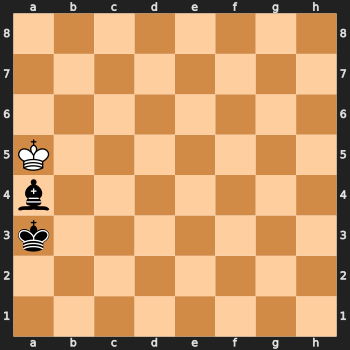

In [39]:
# You might need to install this library
# pip install IPython
import chess.svg
from IPython.display import display, SVG, clear_output
import time

# --- Run the game to get the history ---
game_trajectory, final_reward, game_history = run_self_play_game(model, device)
print(f"Game finished with reward {final_reward} in {len(game_history)-1} moves.")

# --- Visualize the game ---
for fen in game_history:
    # Create an SVG image of the board
    board_svg = chess.svg.board(board=chess.Board(fen), size=350)
    
    # Display in the notebook
    clear_output(wait=True) # Clears the previous board
    display(SVG(board_svg))
    
    # Pause for a moment to see the move
    time.sleep(0.001)

In [35]:
import chess
import torch
from flask import Flask, render_template, request, jsonify, session
from flask_session import Session

# (Place your ActorCritic model, board_to_tensor, and move mapping functions here)
# ... (or import them from another file)

# --- Initialize the Bot ---
device = torch.device("cpu") # Use CPU for inference on a web server
model = ActorCritic(num_actions=NUM_ACTIONS).to(device)
try:
    # 2. Load the saved weights into a temporary variable
    pretrained_dict = torch.load('critic_pretrained_weights.pth')
    
    # 3. Get the state dictionary of our new model
    model_dict = model.state_dict()
    
    # 4. Filter out the mismatched weights (the policy_head)
    # We create a new dictionary containing only the weights from the saved file
    # that exist in the new model AND have the same shape.
    filtered_pretrained_dict = {
        k: v for k, v in pretrained_dict.items() 
        if k in model_dict and v.shape == model_dict[k].shape
    }
    
    # 5. Update the new model's dictionary with our filtered weights
    model_dict.update(filtered_pretrained_dict)
    
    # 6. Load the updated dictionary into the model
    model.load_state_dict(model_dict)
    
    print("Pre-trained weights for shared body and critic head loaded manually and successfully.")
    num_loaded = len(filtered_pretrained_dict)
    print(f"Loaded {num_loaded} matching weight tensors.")
except FileNotFoundError:
    print("No pre-trained weights found. Using a randomly initialized model.")
model.eval()

# --- Flask App Setup ---
app = Flask(__name__)
app.config["SESSION_PERMANENT"] = False
app.config["SESSION_TYPE"] = "filesystem"
Session(app)

def get_bot_move(board):
    """
    This function contains the bot's move-making logic from our self-play loop.
    """
    with torch.no_grad():
        state_tensor = board_to_tensor(board).unsqueeze(0).to(device)
        policy_logits, _ = model(state_tensor)

        legal_move_indices = [move_to_action(move) for move in board.legal_moves]
        mask = torch.ones_like(policy_logits) * -1e9
        mask[0, legal_move_indices] = 0
        
        masked_logits = policy_logits + mask
        probs = torch.nn.functional.softmax(masked_logits, dim=-1)
        
        # Instead of sampling, let's make the bot play the best move it sees
        action_index = torch.argmax(probs).item()
        
        return all_possible_moves[action_index]

@app.route("/")
def index():
    """
    Start a new game and render the board.
    """
    if "board" not in session:
        board = chess.Board()
        session["board"] = board.fen()
    
    return render_template("index.html")

@app.route("/move", methods=["POST"])
def move():
    """
    Handle a player's move and respond with the bot's move.
    """
    board = chess.Board(session["board"])
    
    # Get the player's move from the request
    player_move_uci = request.json.get("move")
    move = chess.Move.from_uci(player_move_uci)
    
    # Make the player's move
    if move in board.legal_moves:
        board.push(move)
    else:
        return jsonify({"error": "Illegal move"}), 400
    
    # Check if the game is over
    if board.is_game_over():
        session["board"] = board.fen()
        return jsonify({"fen": board.fen(), "game_over": True, "result": board.result()})
    
    # Get and make the bot's move
    bot_move = get_bot_move(board)
    board.push(bot_move)
    
    # Store the new board state
    session["board"] = board.fen()
    
    # Check if the game is over after the bot's move
    game_over = board.is_game_over()
    result = board.result() if game_over else None
    
    return jsonify({"fen": board.fen(), "game_over": game_over, "result": result})

if __name__ == "__main__":
    app.run(debug=True, use_reloader=False)

Pre-trained weights for shared body and critic head loaded manually and successfully.
Loaded 27 matching weight tensors.
 * Serving Flask app '__main__'
 * Debug mode: on


C:\Users\Rama Ranuh\AppData\Local\Temp\ipykernel_33256\3286563805.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('critic_pretrained_weight